In [8]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import multiprocessing as mp
import random
from multiprocessing import Pool
import os
from tqdm import tqdm
print("Number of processors: ", mp.cpu_count())
n_process = mp.cpu_count()

Number of processors:  48


In [3]:
%%cython -+ 
cimport cython
import numpy as np
cimport numpy as np

from libc.math cimport exp, tanh
from mc_lib.rndm cimport RndmWrapper
from mc_lib.lattices import tabulate_neighbors
from mc_lib.observable cimport RealObservable
    
cdef void init_spins(long[::1] spins, RndmWrapper rndm): 
    
    for j in range(spins.shape[0]):
        spins[j] = 1 if rndm.uniform() > 0.5 else -1
        
        
        
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double energy(long[::1] spins, 
                   long[:, ::1] neighbors,
                  const double[:,::1] Js):

    cdef:
        double ene = 0.0
        Py_ssize_t site, site1, num_neighb

    for site in range(spins.shape[0]):
        num_neighb = neighbors[site, 0]
        for j in range(1, num_neighb+1):
            site1 = neighbors[site, j]
            ene += -1 * Js[site, site1] * spins[site] * spins[site1] 
    
    return ene / 2.0



@cython.boundscheck(False)
@cython.wraparound(False)
cdef void flip_spin(long[::1] spins, 
                    const long[:, ::1] neighbors,
                    double beta,
                    const double[:,::1] Js, RndmWrapper rndm): 
    cdef:
        Py_ssize_t site = int(spins.shape[0] * rndm.uniform())
        Py_ssize_t site1

    cdef long num_neighb = neighbors[site, 0]
    cdef double summ = 0.
    for j in range(1, num_neighb + 1):
        site1 = neighbors[site, j]
        summ += spins[site1] * spins[site] * Js[site,site1]
   
    cdef double ratio = exp(-2.0 * beta * summ )
    
    if rndm.uniform() > ratio:
        return

    spins[site] = -spins[site]
    
    
cdef void get_J( double[:,::1] Js, double J, double Jd, int L1, int L2):
    
    for i in range(L1*L2):
        Js[i, ((i // L2 + 1) % L1 * L2 )  + (i + 1) % L2 ] = Jd
        Js[i, ((i // L2  - 1) % L1 * L2 )  + (i - 1) % L2 ] = Jd
        Js[i, (i // L2) * L2 + (i + 1) % L2] = J 
        Js[i, (i + L2) % (L1*L2)] = J
        Js[i, (i // L2) * L2 + (i - 1) % L2] = J
        Js[i, (i - L2) % (L1*L2)] = J
    return
        

def simulate(Py_ssize_t L,
             double T, double J, double Jd,
             Py_ssize_t num_sweeps, int seed, int rseed = 1234):

    cdef:
        long[:, ::1] neighbors = tabulate_neighbors(L, kind='triang') 
        double beta = 1./T

    cdef:
        
        int num_therm = int(30 * L)
        int steps_per_sweep = L * L 
        int sweep = 0
        int i
        double Z = 0., magn = 0., binder = 0., error = 0.
        
    
    cdef RndmWrapper rndm = RndmWrapper((rseed, seed)) 
    cdef RealObservable m2 = RealObservable()
    cdef RealObservable m4 = RealObservable()

    cdef long[::1] spins =  np.empty( L*L, dtype=int) 
    init_spins(spins, rndm)
    
    cdef double[:,::1] Js = np.zeros((L*L, L*L)) 
    get_J(Js, J, Jd, L, L)

    for sweep in range(num_therm):
        for i in range(steps_per_sweep):
            flip_spin(spins, neighbors, beta, Js, rndm)

    m = np.zeros(num_sweeps)

    for sweep in range(num_sweeps):
        for i in range(steps_per_sweep):
            flip_spin(spins, neighbors, beta, Js, rndm)
            
        Z += 1
        magn = 0.
        for i in range(L*L):
            magn += spins[i]
            
        m2.add_measurement(magn**2)
        m4.add_measurement(magn**4)
        m[sweep] = magn
        
    binder = 1 - (m4.mean) / (3 * (m2.mean**2))
    
    error = np.sqrt( ( m4.errorbar/( 3*(m2.mean**2)) )**2 + ( 2*(m4.mean)*m2.errorbar/(3*(m2.mean**3) ) )**2 )
     
    return (binder)#, error, m)
  

In [5]:
def cums(data):
    
    # функция для паралелльного запуска
    
    Temps = data[0]
    Jd = data[1]
    T = len(Temps)
    
    sim_len = int(2e6)

    b_120 = np.zeros(T)
    e_120 = np.zeros(T)
    #b_20 = np.zeros(T)
    #e_20 = np.zeros(T)
    #b_40 = np.zeros(T)
    #e_40 = np.zeros(T)
    #b_80 = np.zeros(T)
    #e_80 = np.zeros(T)
    
    seed = os.getpid() 
    
    for j,t in enumerate(Temps):
        b_120[j], e_120[j], m  = simulate(120,t,1,Jd,int(2e6), seed, j)
        #np.save(f'./data_{Jd:.1f}/magn_{20}_{t:.3f}_{Jd:.1f}_{seed}.npy', m) 
        
        #b_20[j], e_20[j], m  = simulate(20,t,1,Jd,sim_len, seed, j)
        #np.save(f'./data_{Jd:.1f}/magn_{20}_{t:.3f}_{Jd:.1f}_{seed}.npy', m) 
        
        #b_40[j], e_40[j], m  = simulate(40,t,1,Jd,sim_len, seed, j)
        #np.save(f'./data_{Jd:.1f}/magn_{40}_{t:.3f}_{Jd:.1f}_{seed}.npy', m) 
        
        #b_80[j], e_80[j], m  = simulate(80,t,1,Jd,sim_len, seed, j)
        #np.save(f'./data_{Jd:.1f}/magn_{80}_{t:.3f}_{Jd:.1f}_{seed}.npy', m) 
        
    return  ((b_120), (e_120)) #((b_120, b_20, b_40, b_80), (e_120, e_20, e_40, e_80))


In [4]:
roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936, 0.03198372863548067]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds,roots))

In [13]:
round(get_crit_T[-0.7],3)

0.854

In [ ]:
%%time
Jd = -0.3
T_crit = round(get_crit_T[Jd],3)



Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 8)
N = 40


T = len(Temps)
data = list(zip([Temps]*N, [Jd]*N))


pool = Pool(N)

res = pool.map(cums, data) 
res = np.asarray(res) 
#np.save(f'res_{Jd:.1f}.npy', res)
# массив (N,2,4,T), где 2 - это пара (средн., ошибка), 4 - количество размеров L  

pool.close()

In [ ]:
Jd = -0.3
T_crit = round(get_crit_T[Jd],3)
N = 100
Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 8)
T = len(Temps)

b_20 = np.zeros((N,T))

for i in tqdm(range(N)):
    for j,t in enumerate(Temps):
        b_20[i,j]  = simulate(20,t,1,Jd,int(2e6), 1234, i)

 56%|█████▌    | 56/100 [4:52:45<3:49:21, 312.76s/it]

In [ ]:
np.save('b_20.npy', b_20)

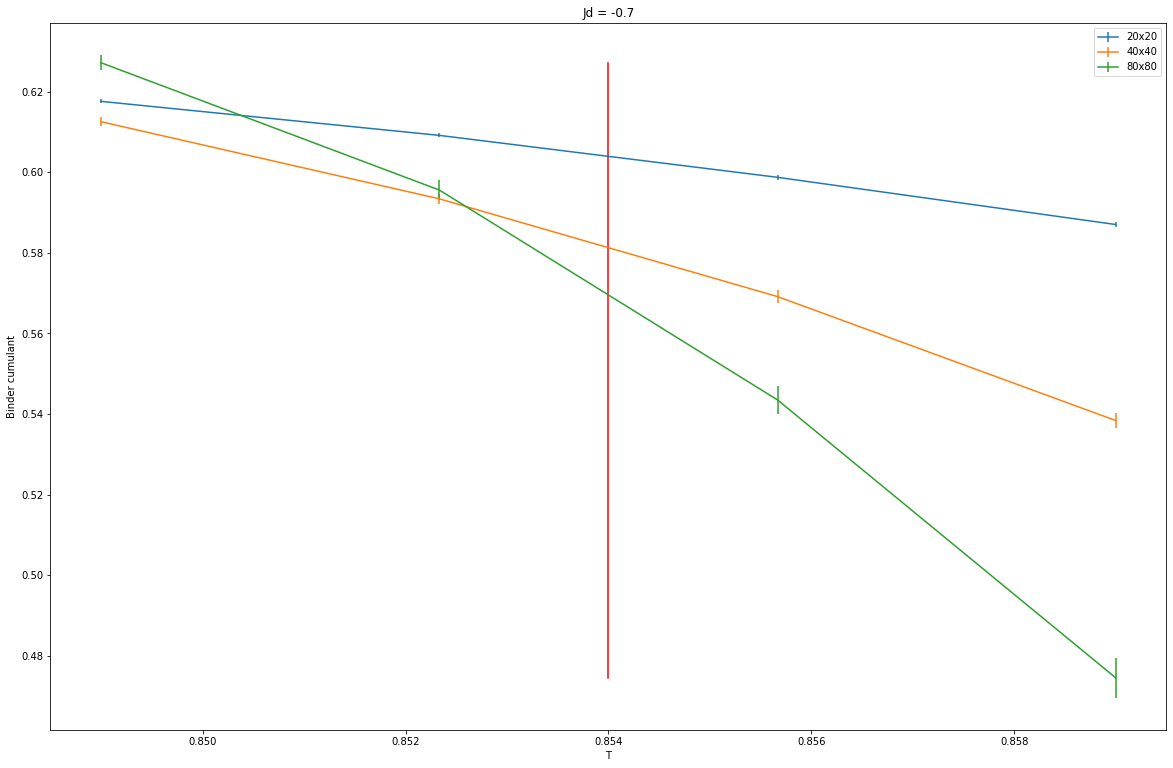

In [13]:
# это для симуляций в 10 раз длиннее (2е7) (13 часов считалось, 4 температуры в  Тс +- 0.005)
plt.figure(figsize=(20,13))
plt.errorbar(Temps, B20, yerr = ErrB20, label = '20x20')
plt.errorbar(Temps, B40, yerr = ErrB40, label = '40x40')
plt.errorbar(Temps, B80, yerr = ErrB80, label = '80x80')
plt.plot([T_crit]*20, np.linspace(B80[0], B80[-1], 20), c = 'r')
plt.legend()
plt.title(f'Jd = {Jd}')

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()

In [136]:
Jd = 0.0
res = np.load(f'res_{Jd}_b.npy')
T_crit = round(get_crit_T[Jd],3)
Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 8)
N = 40
T = len(Temps)

In [137]:
binder_120 = np.zeros((N,T))
binder_20 = np.zeros((N,T))
binder_40 = np.zeros((N,T))
binder_80 = np.zeros((N,T))

err_120 = np.zeros((N,T))
err_20 = np.zeros((N,T))
err_40 = np.zeros((N,T))
err_80 = np.zeros((N,T))

In [138]:
for i in range(N):
    binder_120[i] = res[i,0,0]
    binder_20[i] = res[i,0,1]
    binder_40[i] = res[i,0,2]
    binder_80[i] = res[i,0,3]
    
    err_120[i] = res[i,1,0]
    err_20[i] = res[i,1,1]
    err_40[i] = res[i,1,2]
    err_80[i] = res[i,1,3]

In [112]:
binder_20[6]

array([0.63342583, 0.61629093, 0.60883896, 0.6096086 , 0.60308558,
       0.58538196, 0.57600064, 0.57074136])

In [4]:
b_20 = np.load("b_20.npy")
N=100

In [5]:
binder_20_0 = [b_20[i, 0] for i in range(N)] 
binder_20_2 = [b_20[i, 2] for i in range(N)] 
binder_20_4 = [b_20[i, 4] for i in range(N)] 
binder_20_7 = [b_20[i, 7] for i in range(N)] 

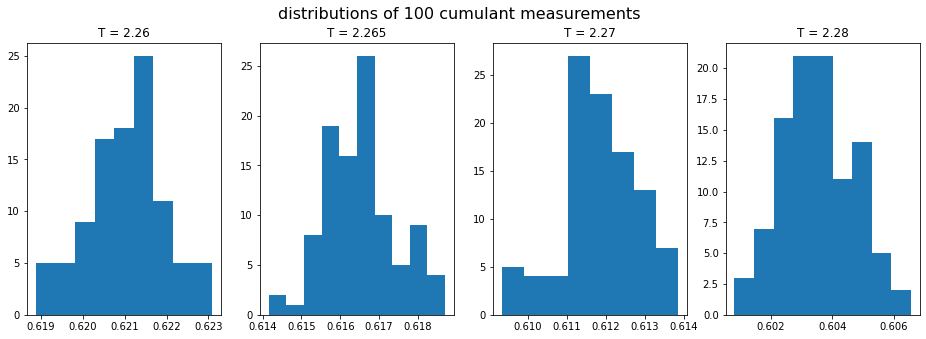

In [7]:

b  = 'auto'
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (16,5))
ax1.hist(binder_20_0, bins = b)
ax1.set_title('T = 2.26')

ax2.hist(binder_20_2, bins = b)
ax2.set_title('T = 2.265')

ax3.hist(binder_20_4, bins = b)
ax3.set_title('T = 2.27')

ax4.hist(binder_20_7, bins = b)
ax4.set_title('T = 2.28')

fig.suptitle('distributions of 100 cumulant measurements', fontsize=16)
plt.show()

In [11]:
def calculate_distribution(Bs, dBs):
    
    N = len(Bs) 
    # В измерен N раз с ошибкой
    
    Norms = np.zeros((N,1000))
    
    for i in range(N):
        for j in range(1000):
            Norms[i,j] = random.normalvariate(mu = Bs[i], sigma = dBs[i]) 
            # генерируем N выборок обьемом 1000 из норм. распределения с соотв. матожиданием и отклонением
    
    Norm = np.zeros(1000)
    for i in range(1000):
        Norm[i] = np.mean([Norms[_,i] for _ in range(N)]) 
        # усредняем выборки, получаем распределение с какими то усредненными матожиданием и дисперсией
    
    
    return (np.mean(Norm), np.std(Norm)) # полученные матож. и дисперсия       

In [139]:
# вычисление среднего и ошибки

B120 = np.zeros(T)
ErrB120 = np.zeros(T)

B20 = np.zeros(T)
ErrB20 = np.zeros(T)

B40 = np.zeros(T)
ErrB40 = np.zeros(T)

B80 = np.zeros(T)
ErrB80 = np.zeros(T)

for i in range(T):
    B120s = [binder_120[_,i] for _ in range(N)]
    dB120s = [err_120[_,i] for _ in range(N)]
    B120[i], ErrB120[i] = calculate_distribution(B120s, dB120s)
    
    B20s = [binder_20[_,i] for _ in range(N)]
    dB20s = [err_20[_,i] for _ in range(N)]
    B20[i], ErrB20[i] = calculate_distribution(B20s, dB20s)
    
    B40s = [binder_40[_,i] for _ in range(N)]
    dB40s = [err_40[_,i] for _ in range(N)]
    B40[i], ErrB40[i] = calculate_distribution(B40s, dB40s)
    
    B80s = [binder_80[_,i] for _ in range(N)]
    dB80s = [err_80[_,i] for _ in range(N)]
    B80[i], ErrB80[i] = calculate_distribution(B80s, dB80s)

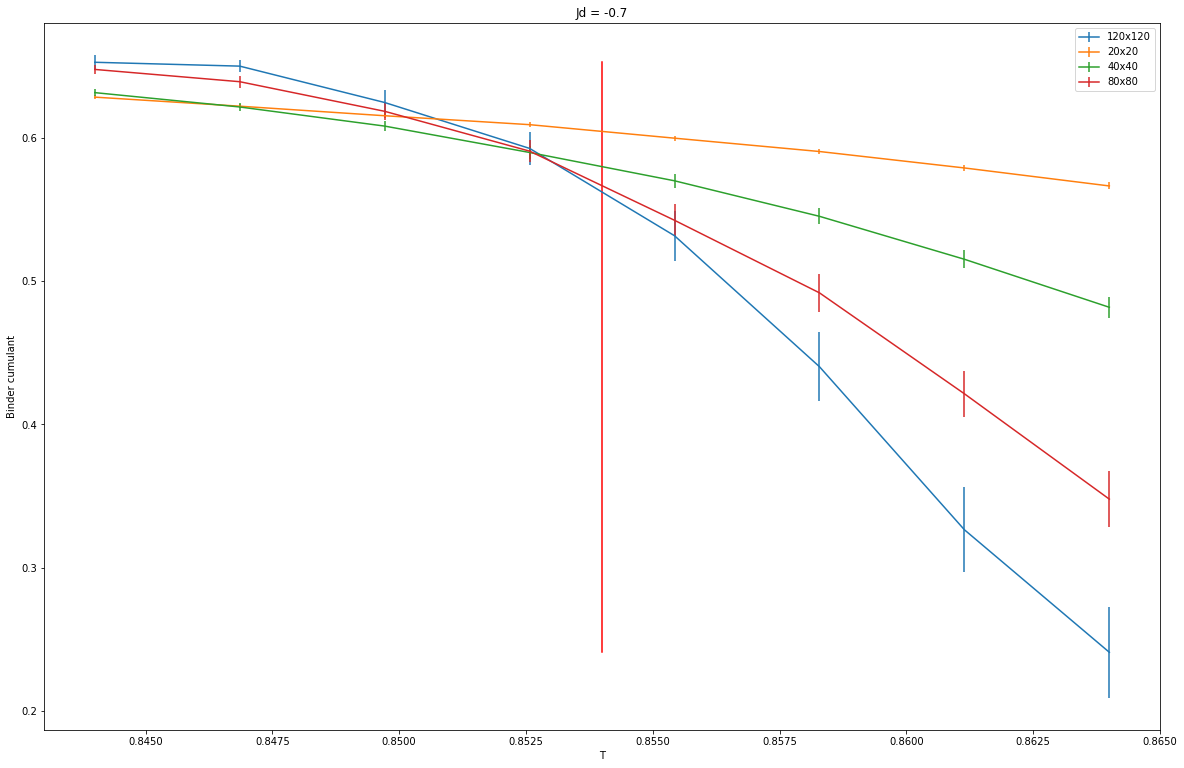

In [128]:
Jd = -0.7
T_crit = round(get_crit_T[Jd],3)
Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 8)

plt.figure(figsize=(20,13))
plt.errorbar(Temps, B120, yerr = ErrB120, label = '120x120')
plt.errorbar(Temps, B20, yerr = ErrB20, label = '20x20')
plt.errorbar(Temps, B40, yerr = ErrB40, label = '40x40')
plt.errorbar(Temps, B80, yerr = ErrB80, label = '80x80')
plt.plot([T_crit]*20, np.linspace(B120[0], B120[-1], 20), c = 'r')
plt.legend()
plt.title(f'Jd = {Jd}')

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()

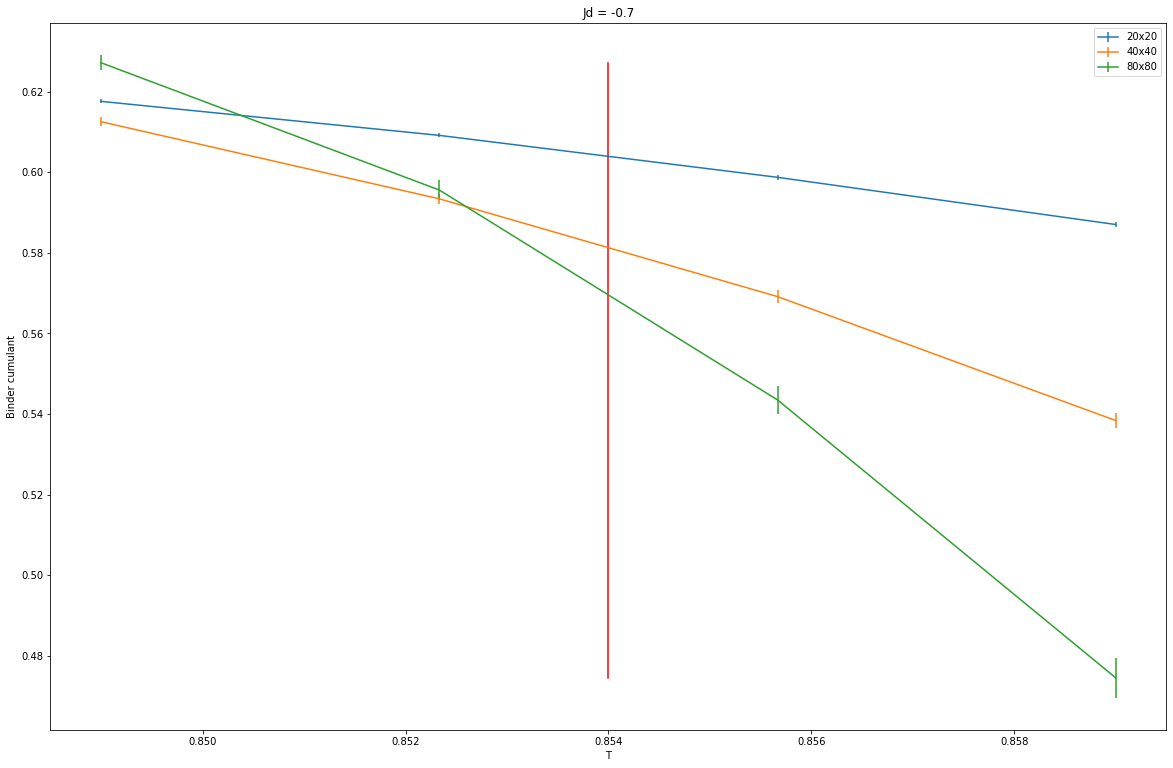

In [14]:
plt.figure(figsize=(20,13))
plt.errorbar(Temps, B20, yerr = ErrB20, label = '20x20')
plt.errorbar(Temps, B40, yerr = ErrB40, label = '40x40')
plt.errorbar(Temps, B80, yerr = ErrB80, label = '80x80')
plt.plot([T_crit]*20, np.linspace(B80[0], B80[-1], 20), c = 'r')
plt.legend()
plt.title(f'Jd = {Jd}')

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()
# для длинных выборок

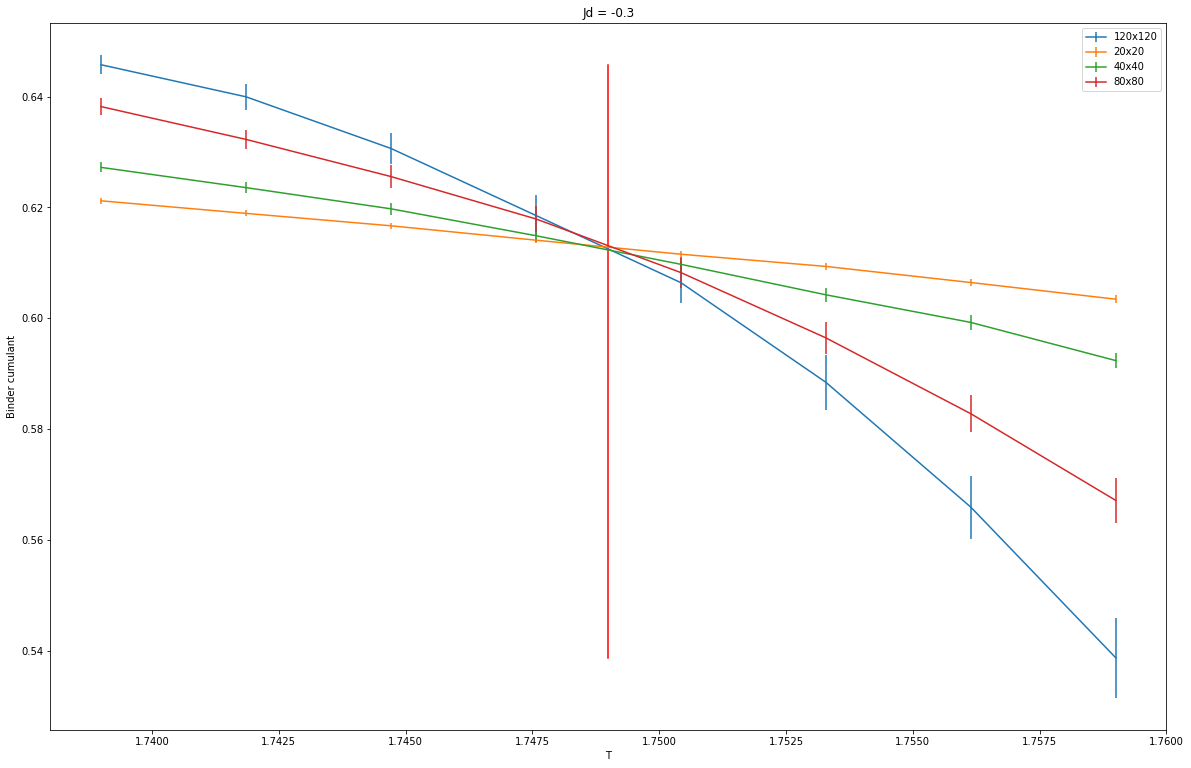

In [133]:
Jd = -0.3
T_crit = round(get_crit_T[Jd],3)
Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 8)

plt.figure(figsize=(20,13))
plt.errorbar(Temps, B120, yerr = ErrB120, label = '120x120')
plt.errorbar(Temps, B20, yerr = ErrB20, label = '20x20')
plt.errorbar(Temps, B40, yerr = ErrB40, label = '40x40')
plt.errorbar(Temps, B80, yerr = ErrB80, label = '80x80')
plt.plot([T_crit]*20, np.linspace(B120[0], B120[-1], 20), c = 'r')
plt.legend()
plt.title(f'Jd = {Jd}')

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()

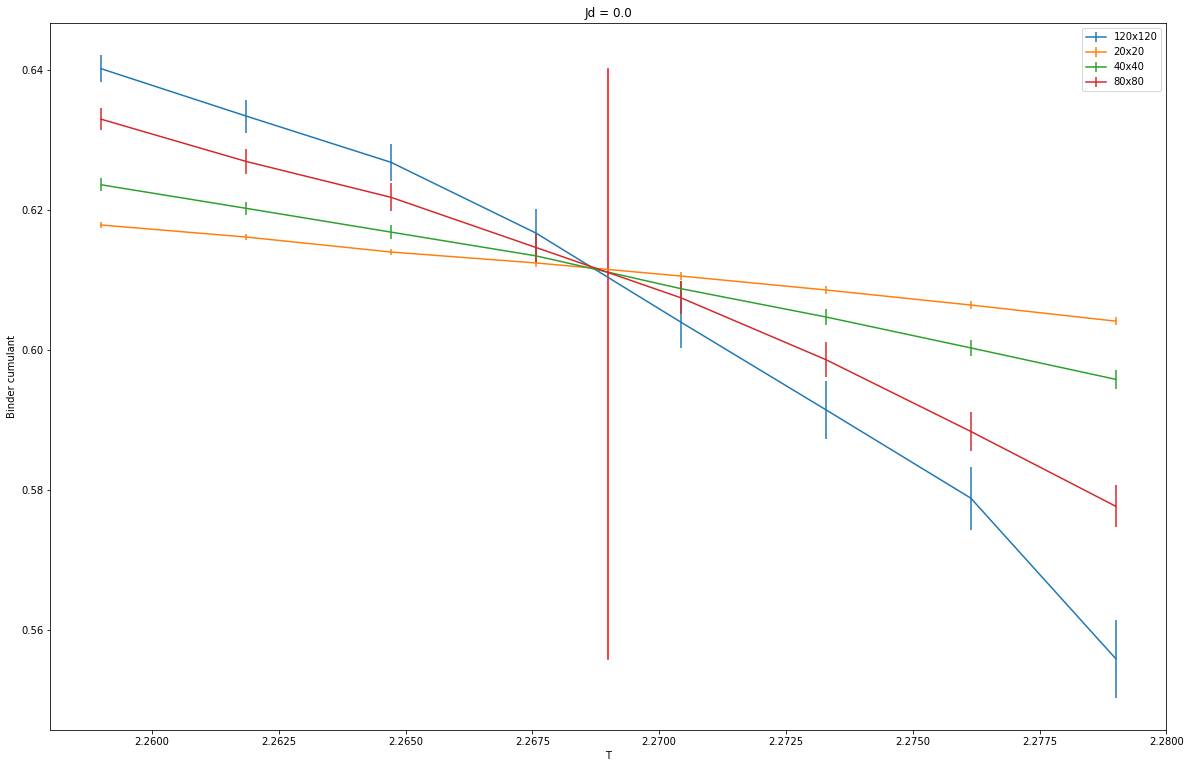

In [140]:
Jd = 0.0
T_crit = round(get_crit_T[Jd],3)
Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 8)

plt.figure(figsize=(20,13))
plt.errorbar(Temps, B120, yerr = ErrB120, label = '120x120')
plt.errorbar(Temps, B20, yerr = ErrB20, label = '20x20')
plt.errorbar(Temps, B40, yerr = ErrB40, label = '40x40')
plt.errorbar(Temps, B80, yerr = ErrB80, label = '80x80')
plt.plot([T_crit]*20, np.linspace(B120[0], B120[-1], 20), c = 'r')
plt.legend()
plt.title(f'Jd = {Jd}')

plt.xlabel("T")
plt.ylabel("Binder cumulant")
plt.show()